<a href="https://colab.research.google.com/github/adasegroup/ML2021_seminars/blob/master/seminar12/Bayesian_ML_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seminar 12: Bayesian Neural Netwroks

In [1]:
import torch
from torch import nn
from torch.functional import F
from torch.autograd import Variable

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Introduction

Consider a dataset of a small size.

In [2]:
def get_and_plot(N=100, noise=0., random_state=None, train_size=0.1):
    X, y = make_moons(noise=noise, random_state=random_state, n_samples=int(N/train_size))
    X, y = Variable(torch.from_numpy(X.astype('float32'))), Variable(torch.from_numpy(y))
    X = X.to(device)
    y = y.to(device)

    train_idx, test_idx = train_test_split(range(len(X)), train_size=train_size, random_state=0, stratify=y.cpu())

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    fig, ax = plt.subplots(1,2, figsize=(15, 5))
    ax[0].scatter(X[:,0].cpu(), X[:,1].cpu(), c=y.cpu(), cmap='bwr')
    ax[0].set(title=f"Moons of size {10*N}", xlabel="X", ylabel="Y");

    ax[1].scatter(X_train[:,0].cpu(), X_train[:,1].cpu(), c=y_train.cpu(), cmap='bwr')
    ax[1].set(title=f"Train sample of size {N}", xlabel="X", ylabel="Y");
    plt.show()
    
    return X_train, X_test, y_train, y_test

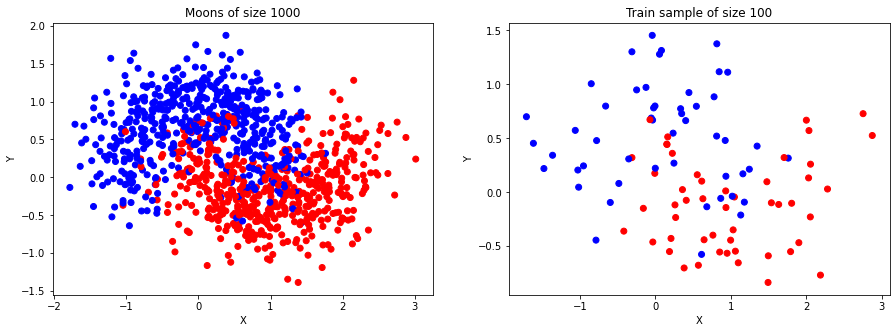

In [3]:
X_train, X_test, y_train, y_test = get_and_plot(N=100, noise=0.35, random_state=42, train_size=0.1)

Our task is to build a classification neural network on the small train sample. <br>
We can see that the data is noisy, and there is no perfect separation between classes. <br>

It is **unclear** what decision boundary will be the optimal.

It is an important moment that we can use <ins>**only**</ins> the train set. <br>
We will test our model, but we can't choose the number of epochs or other hyperparameters looking at the test score. <br>
Splitting the train set is also a bad idea since there are too few observations.

## Simple Neural Network

Consider a simple Fully-Connected NN with three layers, batch-normalization, and tanh activation. <br>
The first two layers are feature-extractors. The last layer is the predictor.

In [4]:
class Net(nn.Module):
    Linear = nn.Linear
    
    def __init__(self, in_features=1, hidden=1, n_classes=2):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            self.Linear(in_features, hidden, bias=False),
            nn.BatchNorm1d(hidden), nn.Tanh(),
            self.Linear(hidden, hidden, bias=False),
            nn.BatchNorm1d(hidden), nn.Tanh()
        )
        self.out = nn.Linear(hidden, n_classes)
        
    def forward(self, x):
        x = self.features(x)
        x = F.log_softmax(self.out(x), dim=1)
        return x

Define the plotting function. It is just a hand-written tool for plotting the boundaries.

In [5]:
def plot_boundaries(model, X, y, X_test, y_test, epoch, plot_uncertainty=False, print_score=False, alpha=1.0,
                   fig = None, ax=None, samples=1):
    model.eval()
    
    xx = np.linspace(X.cpu()[:,0].min()-1., X.cpu()[:,0].max()+1., 50)
    yy = np.linspace(X.cpu()[:,1].min()-1., X.cpu()[:,1].max()+1., 50)
    mesh = np.meshgrid(xx, yy)
    a = np.zeros((2500,2))
    a[:,0], a[:,1] = np.ravel(mesh[0]), np.ravel(mesh[1])
    contour_test = torch.Tensor(a).to(device)

    if 'ensemble_pred' in globals():
        if plot_uncertainty:
            cmap = sns.cubehelix_palette(light=1, as_cmap=True)
            _, predict_out = ensemble_pred(model, contour_test, N=1000)
        else:
            cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
            predict_out, _ = ensemble_pred(model, contour_test, N=100)
    else:
        cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
        predict_out = torch.exp(model(contour_test))

    contour_plot = predict_out.cpu().detach().numpy()[:,1]
   
    title = f'epoch: {epoch} | '
    if print_score:
        if 'ensemble_pred' in globals(): 
            y_pred, _ = ensemble_pred(model, X, N=samples)
        else:
            y_pred = model(X)
        train_score = (y_pred.argmax(1)==y).float().mean().item()
        title += f'train: {100*train_score:.2f}% | ' 
        
        if 'ensemble_pred' in globals(): 
            y_pred, _ = ensemble_pred(model, X_test, N=samples)
        else:
            y_pred = model(X_test)
        test_score = (y_pred.argmax(1)==y_test).float().mean().item()
        title += f'test: {100*test_score:.2f}%' 

    if fig is None:
        fig, ax = plt.subplots(figsize=(8, 5))
    contour = ax.contourf(mesh[0], mesh[1], contour_plot.reshape(50,50), 10, cmap=cmap);
    #cbar = plt.colorbar(contour)
    ax.scatter(X.cpu()[:,0], X.cpu()[:,1], c=y.cpu(), cmap='bwr', alpha=alpha)
    sns.despine()
    ax.set(xlabel='X', ylabel='y', title=title)
    cbar = plt.colorbar(contour, ax=ax)
    if fig is None:
        plt.show()
    return train_score, test_score

### Task 1
Write a training procedure for NN.

In [6]:
def train(model, X, y, criterion, optimizer):
    '''
    model - our NN
    X - input Tensor with size (batch_size, n_features)
    y - labels Tensor with size (batch_size)
    criterion - loss function
    optimizer - optimizer
    '''

In [7]:
# Solution
def train(model, X, y, criterion, optimizer):
    '''
    model - our NN
    X - input Tensor with size (batch_size, n_features)
    y - labels Tensor with size (batch_size)
    criterion - loss function
    optimizer - optimizer
    '''
    model.train()
    optimizer.zero_grad()  
    y_pred = model(X)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()

Let's look on the visualization of training progress. <br>
We use Adam optimizer. <br>
Our loss function is Negative Log-Likelihood Loss (NLLLoss).<br>

We will fix weight initialization for better comparison later.

We have a toy and a low-memory dataset, so there is no need to uses batches. We will use the whole set for each epoch.

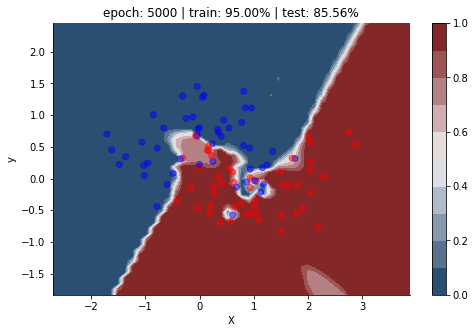

In [8]:
torch.manual_seed(42)

model = Net(in_features=2, hidden=5, n_classes=2).to(device)

epochs = 5000
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.NLLLoss(reduction='sum')

train_score, test_score = plot_boundaries(model, X_train, y_train, X_test, y_test, 0,
                                          alpha=0.5, plot_uncertainty=False, print_score=True)
plt.show()
clear_output(wait=True)

train_scores, test_scores = [train_score], [test_score]

steps = (np.logspace(-np.log10(epochs), 0, 200)*epochs).astype(int)
steps = np.unique(np.hstack([0, steps]))

for epoch in range(1, epochs + 1):
    train(model, X_train, y_train, criterion, optimizer)
        
    if epoch in steps:        
        train_score, test_score = plot_boundaries(model, X_train, y_train, X_test, y_test, epoch,
                                                  alpha=0.5, plot_uncertainty=False, print_score=True)
        plt.show()
        clear_output(wait=True) 
        train_scores.append(train_score)
        test_scores.append(test_score)


We have seen quite strange behavior outside our set. It is because we consider only training set and other areas of feature space out of our interest. <br>
Also, we see that the model starts to overfit.

Let's look at the score function during the training process.

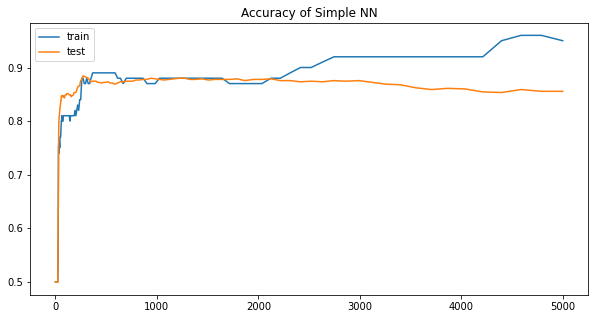

In [9]:
plt.figure(figsize=(10,5))
plt.plot(steps, train_scores, label='train')
plt.plot(steps, test_scores, label='test')
plt.legend()
plt.title('Accuracy of Simple NN')
plt.show()

We see that score starts to degrade, which means that the model starts to overfit. 

There were iterations where when our model didn't start to overfit, but we can't catch this moment.

## Bayesian approach: Bayesian Neural Networks

Bayes Rule:

$$
p(A|B) = \frac{p(B|A)p(A)}{p(B)},
$$

$p(A)$ - prior probability,<br>
$p(A|B)$ - posterior probability.

Consider the data $D$. We assume that the weight $W$ of our model has prior distribution $p(W)$. Then we get

$$
p(W|D) = \frac{p(D|W)p(W)}{p(D)} =\frac{p(D|W)p(W)}{\int p(D|W)p(W)dW}.
$$
The $p(D|W)$ is the likelihood, and $p(W|D)$ is the posterior distribution of our weights.<br>
The denominator, in most cases, is intractable, so we can't compute the posterior explicitly.

We will try to approximate the true posterior with some parametric distribution $q_{\theta}(W)$.

<img src=https://github.com/adasegroup/ML2021_seminars/raw/main/seminar12/imgs/posterior_approx.png>

### Variational inference

So, our task now is to minimize KL-divergence between these distributions.<br>
But we don't know the true posterior!

$$
KL\big(q_{\theta}(W)\|p(W|D)\big) \to \underset{\theta}{min}
$$

Rewrite KL-divergence:

$$
KL\big(q_{\theta}(W)\|p(W|D)\big) = \int q_{\theta}(W)\ln\frac{q_{\theta}(W)p(D)}{p(W,D)}dW = \int q_{\theta}(W)\bigg[\ln\frac{q_{\theta}(W)}{p(D|W)p(W)} + \ln p(D)\bigg] dW;
$$

$$
KL\big(q_{\theta}(W)\|p(W|D)\big) = \int q_{\theta}(W)\ln\frac{q_{\theta}(W)}{p(W)}dW - \int q_{\theta}(W)\ln p(D|W)dW + \ln p(D);
$$

$$
KL\big(q_{\theta}(W)\|p(W|D)\big) = KL\big(q_{\theta}(W)\|p(W)\big) - E_{q_{\theta}(W)}\ln p(D|W) + \ln p(D);
$$

$$
\ln p(D) - KL\big(q_{\theta}(W)\|p(W|D)\big) = E_{q_{\theta}(W)}\ln p(D|W) - KL\big(q_{\theta}(W)\|p(W)\big).
$$

Evidence Lower Bound (ELBO):
$$
ELBO(X) = E_{q_{\theta}(W)}\ln p(D|W) - KL\big(q_{\theta}(W)\|p(W)\big) \to \underset{\theta}{max}
$$


As $KL\big(q_{\theta}(W)\|p(W|D)\big)\geqslant 0$, this equation shows that the evidence lower bound is indeed a lower bound on the log-evidence $\ln P(D)$ for the model considered. As $\ln P(D)$ does not depend on $\theta$ this equation additionally shows that maximizing the evidence lower bound on the right minimizes $KL\big(q_{\theta}(W)\|p(W|D)\big)$, as claimed above.

In our case the, $-E_{q_{\theta}(W)}\ln p(D|W)$ is the negative log-likelihood loss (NLLLoss) (**not averaged!**).

Ok, we want to maximize ELBO with Gradient Descend and update weights with backpropagation.<br>
How to backpropagate through random weight?<br>

Answer: Reparameterization trick [(Kingma, 2014)](https://arxiv.org/abs/1312.6114)

<img src=https://github.com/adasegroup/ML2021_seminars/raw/main/seminar12/imgs/trick.png>

### Task 2. 
Suppose that all weights are independent.<br>
Let the prior be a factorized $N(0,I)$ and we approximate true posterior with factorized $N(a_i, \sigma_i^2I)$, i.e., factorized normal distribution with mean vector $a$ and covariance matrix $\sigma^2I$.<br>
Write a function for the reparametrization trick.

In [10]:
def rnormal(mean, var):
    '''
    mean - mean value
    var - variance
    
    output: 
    a sample from N(mean, var) and the same shape as mean.
    '''
    pass

In [11]:
# Solution
def rnormal(mean, var):
    '''
    mean - mean value
    var - variance
    '''
    eps = torch.randn_like(mean).to(device)
    return eps * torch.sqrt(var) + mean

In other words, maximizing ELBO is maximizing log-likelihood with additional weights regularization. 

Further, we also suppose that weights are independent.
We use factorized $N(0,I)$ prior and we approximate true posterior with factorized $N(a_i, \sigma_i^2I)$.<br>

It means that each weight's distribution is defined by its mean and variance.

Now we will write a BayesLinear class for Bayesian fully-connected layer. <br>
**Question**: How to inizialize weight's variance?

In [12]:
# Answer: with small values

### Task 3.
Write the **.forward** method.

In [13]:
class BayesLinear(nn.Module):
    def __init__(self, in_features=1, out_features=1, bias=True):
        super(BayesLinear, self).__init__()

        self.add_bias = bias
        
        # W_mean
        self.weight = nn.Parameter(torch.zeros(out_features, in_features))
        nn.init.xavier_normal_(self.weight)

        # W_variance
        self.weight_var = nn.Parameter(torch.zeros(out_features, in_features))
        nn.init.constant_(self.weight_var, -10.)
        
        if self.add_bias:
            # b_mean
            self.bias = nn.Parameter(torch.zeros(1, out_features))
            nn.init.xavier_normal_(self.bias, 0)
            
            # b_variance
            self.bias_var = nn.Parameter(torch.zeros(1, out_features))
            nn.init.constant_(self.bias_var, -10.)
    
    def kl(self, prior):
        p = torch.distributions.Normal(self.weight, torch.sqrt(F.softplus(self.weight_var)))
        kl = torch.distributions.kl_divergence(p, prior).sum()
        if self.add_bias:
            p = torch.distributions.Normal(self.bias, torch.sqrt(F.softplus(self.bias_var)))
            kl += torch.distributions.kl_divergence(p, prior).sum()
        return kl
    
    def forward(self, x):
        '''
        x - input Tensor of size (batch_size, in_features)
        '''
        # Sample W, b given its mean and variance. Then make linear prediction
        W = rnormal(self.weight, F.softplus(self.weight_var))
        b = rnormal(self.bias_mean, F.softplus(self.bias_var)) if self.add_bias else 0.
        return torch.matmul(x, W.T) + b

In [14]:
# Solution
def forward(self, x):
    # Sample W, b given its mean and variance. Then make linear prediction
    W = rnormal(self.weight, F.softplus(self.weight_var))
    b = rnormal(self.bias_mean, F.softplus(self.bias_var)) if self.add_bias else 0.
    return torch.matmul(x, W.T) + b



Let's change our feature extractor's linear layers with bayesian ones.<br>
Also, we add a function to compute KL-divergence over all BaysianLinear layers in our net.

In [15]:
class BayesNet(Net):
    Linear = BayesLinear
    
    def kl(self, prior):
        kl = 0
        for x in self.modules():
            if isinstance(x, BayesLinear):
                kl += x.kl(prior)
        return kl

The predictions of Bayesian NN are not deterministic. The weights are sampled each time.<br>
To more accurate results, you should average the predicted probabilities.

<img src=https://github.com/adasegroup/ML2021_seminars/raw/main/seminar12/imgs/dist.png>

## Task 4.
Write the **ensemble_pred** function, which returns the mean and standard deviation of N sampled **probabilities**.<br>
Please take into account that model outputs are **log-probabilities**.

In [16]:
def ensemble_pred(model, X, N=1):
    '''
    model - our NN
    X - input tensor of size (batch_size, n_features)
    N - number of samples
    
    output: (mean, std) - mean and std of N probabilities for each observation.
    '''

    return 

In [17]:
# Solution
def ensemble_pred(model, X, N=1):
    '''
    model - our NN
    X - input tensor of size (batch_size, n_features)
    N - number of samples
    
    output: (mean, std) - mean and std of N probabilities for each observation.
    '''
    y_preds = []
    with torch.no_grad():
        for i in range(N):
            y_preds.append(model(X))
    y_preds = torch.stack(y_preds)
    y_preds = torch.exp(y_preds)

    return y_preds.mean(0), y_preds.std(0)

Consider again our classification problem.

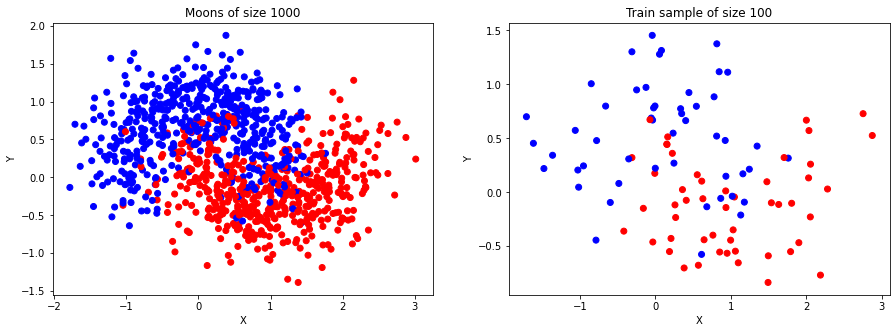

In [18]:
X_train, X_test, y_train, y_test = get_and_plot(N=100, noise=0.35, random_state=42, train_size=0.1)

Define the util function to fix weights initialization.

In [19]:
def initBayesNet(model, seed=42):
    torch.manual_seed(seed)
    model_buf = Net(in_features=2, hidden=5, n_classes=2).to(device)
    params1 = model.named_parameters()
    params2 = model_buf.named_parameters()
    dict_params1 = dict(params1)

    for name2, param2 in params2:
        if name2 in dict_params1:
            dict_params1[name2].data.copy_(param2.data)

Prepare our model.

In [20]:
model = BayesNet(in_features=2, hidden=5, n_classes=2).to(device) 
initBayesNet(model, seed=42)

Set the prior for our weights.

In [21]:
prior = torch.distributions.Normal(torch.Tensor([0.]).to(device), torch.Tensor([1.]).to(device))

### Task 5.
Write a training procedure for Bayesian NN.<br>
*Hint*: there will be the only difference in the loss function.

In [22]:
def train_bayes(model, X, y, criterion, optimizer):
    '''
    model - our NN
    X - input Tensor with size (batch_size, n_features)
    y - labels Tensor with size (batch_size)
    criterion - Negative Log-Likelihood
    optimizer - optimizer
    '''

In [23]:
# Solution
def train_bayes(model, X, y, criterion, optimizer):
    '''
    model - our NN
    X - input Tensor with size (batch_size, n_features)
    y - labels Tensor with size (batch_size)
    criterion - Negative Log-Likelihood
    optimizer - optimizer
    '''
    model.train()
    optimizer.zero_grad()
    y_pred = model(X)
    loss = criterion(y_pred, y)
    loss += model.kl(prior)
    loss.backward()
    optimizer.step()  

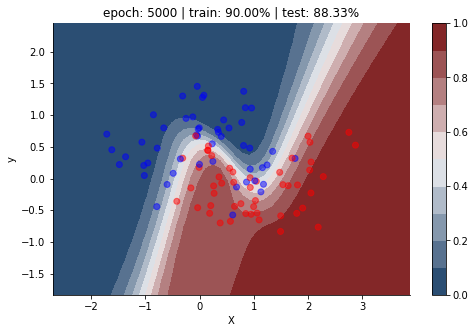

In [24]:
epochs = 5000

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss(reduction='sum')

train_score, test_score = plot_boundaries(model, X_train, y_train, X_test, y_test, 0,
                                          alpha=0.5, plot_uncertainty=False, print_score=True, samples=100)
plt.show()
clear_output(wait=True)

train_scores, test_scores = [train_score], [test_score]

steps = (np.logspace(-np.log10(epochs), 0, 200)*epochs).astype(int)
steps = np.unique(np.hstack([0, steps]))

for epoch in range(1, epochs + 1):
    
    train_bayes(model, X_train, y_train, criterion, optimizer)   
        
    if epoch in steps:        
        train_score, test_score = plot_boundaries(model, X_train, y_train, X_test, y_test, epoch,
                                                  alpha=0.5, plot_uncertainty=False, print_score=True, samples=100)
        plt.show()
        clear_output(wait=True) 
        train_scores.append(train_score)
        test_scores.append(test_score)        


Decision boundary becomes smoother and wider.<br>
The regularization works!

Let's plot the scores.

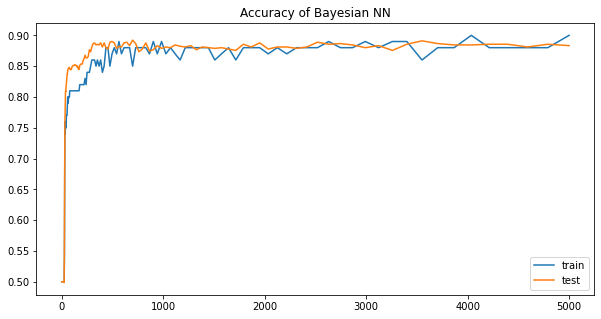

In [25]:
plt.figure(figsize=(10,5))
plt.plot(steps, train_scores, label='train')
plt.plot(steps, test_scores, label='test')
plt.legend()
plt.title('Accuracy of Bayesian NN')
plt.show()

No overfitting!!!<br>
As we can see bayesian approach helps us to regularize weights. <br>
The model doesn't start to overfit during the entire training process. So we can be calm and get a good classifier at the end of the training.

As we said, the prediction of the bayesian model is not fixed. Such a phenomenon is called uncertainty.<br>
Our model is uncertain about prediction.

Is our model uncertain everywhere, or are there specific areas where it so? Let's look at it.

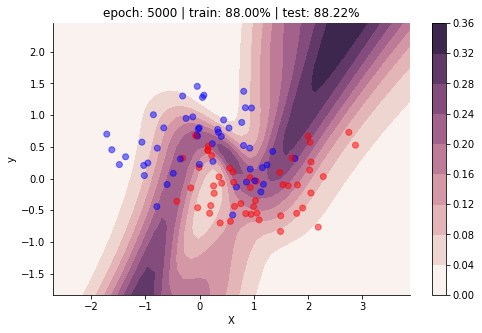

In [26]:
plot_boundaries(model, X_train, y_train, X_test, y_test, epoch,
                        alpha=0.5, plot_uncertainty=True, print_score=True, samples=100);

As expected, an uncertain area is a boundary. <br>
The most uncertain area is the edges of the boundary. It is reasonable since we don't actually know how the moons will behave there.

## Comparison on not-small data

As we can see in ELBO loss, the more data we have, the less KL-divergence affects the final loss.<br>
Consider the dataset of a bigger size. Will we save the profits of Bayesian NN?

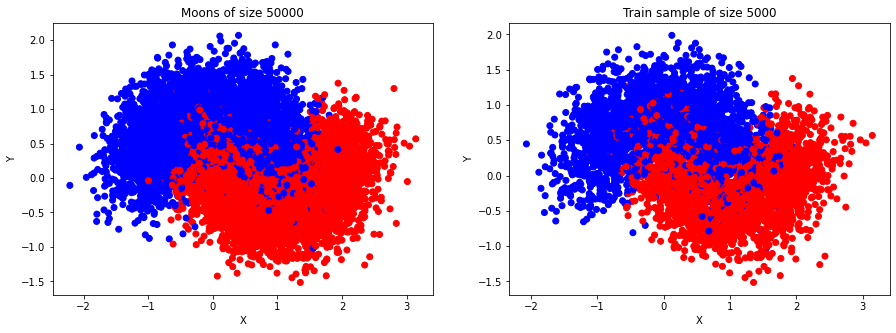

In [27]:
X_train, X_test, y_train, y_test = get_and_plot(N=5000, noise=0.35, random_state=42, train_size=0.5)

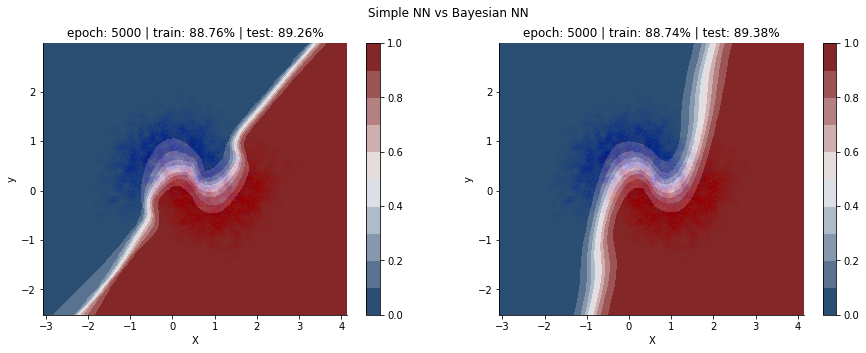

In [29]:
torch.manual_seed(42)
model_1 = Net(in_features=2, hidden=5, n_classes=2).to(device)

model_2 = BayesNet(in_features=2, hidden=5, n_classes=2).to(device)
initBayesNet(model_2, seed=42)

epochs = 5000
lr = 0.001
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=lr)
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=lr)

criterion = nn.NLLLoss(reduction='sum')

fig, ax = plt.subplots(1,2, figsize=(15, 5))
fig.suptitle('Simple NN vs Bayesian NN')
             
plot_boundaries(model_1, X_train, y_train, X_test, y_test, 0,
                alpha=0.01, plot_uncertainty=False, print_score=True, fig=fig, ax=ax[0])
plot_boundaries(model_2, X_train, y_train, X_test, y_test, 0,
                alpha=0.01, plot_uncertainty=False, print_score=True, fig=fig, ax=ax[1], samples=10)
plt.show()
clear_output(wait=True)

steps = (np.logspace(-np.log10(epochs), 0, 200)*epochs).astype(int)
steps = np.unique(np.hstack([0, steps]))

for epoch in range(1, epochs + 1):
    
    train(model_1, X_train, y_train, criterion, optimizer_1)
    
    train_bayes(model_2, X_train, y_train, criterion, optimizer_2) 
        
    if epoch in steps:
        fig, ax = plt.subplots(1,2, figsize=(15, 5))
        fig.suptitle('Simple NN vs Bayesian NN')
        plot_boundaries(model_1, X_train, y_train, X_test, y_test, epoch,
                        alpha=0.01, plot_uncertainty=False, print_score=True, fig=fig, ax=ax[0])
        plot_boundaries(model_2, X_train, y_train, X_test, y_test, epoch,
                        alpha=0.01, plot_uncertainty=False, print_score=True, fig=fig, ax=ax[1], samples=10)
        plt.show()
        clear_output(wait=True) 


With a larger amount of data, Simple NN became more stable and less prone to overfitting.<br>
The scores are quite similar. But we can see that the boundary of Bayesian NN is still more generalized.

## EOF